In [ ]:
# ============================================================
# IMPORT LIBRARY (jalankan sekali di awal notebook)
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import math
import warnings
warnings.filterwarnings('ignore')

# Kalau mau LSTM, pastikan tensorflow sudah ter-install:
# pip install tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


# DAY 1 – Pemilihan Dataset & Explore Dataset

In [ ]:
# ============================================================
# DAY 1 – Pemilihan Dataset & Explore Dataset
# ============================================================

# Sesuaikan path file dengan lokasi di laptop kamu
file_path = "/content/drive/MyDrive/01. Dibimbing/Final Project Dibimbin-Saintis/finance_economics_dataset.csv"

df = pd.read_csv(file_path)

print("Shape dataset:", df.shape)
df.head()

Shape dataset: (3000, 24)


,Date,Stock Index,Open Price,Close Price,Daily High,Daily Low,Trading Volume,GDP Growth (%),Inflation Rate (%),Unemployment Rate (%),...,Forex USD/EUR,Forex USD/JPY,Crude Oil Price (USD per Barrel),Gold Price (USD per Ounce),Real Estate Index,Retail Sales (Billion USD),Bankruptcy Rate (%),Mergers & Acquisitions Deals,Venture Capital Funding (Billion USD),Consumer Spending (Billion USD)
0,2000-01-01,Dow Jones,2128.75,2138.48,2143.70,2100.55,2670411,-0.37,6.06,6.10,...,1.04,119.87,47.20,1052.34,390.23,2229,2.12,3,76.64,4589
1,2000-01-02,S&P 500,2046.82,2036.18,2082.83,2009.53,690220415,3.19,4.95,6.62,...,1.00,98.22,52.84,1957.73,346.23,4156,1.40,21,5.67,10101
2,2000-01-03,Dow Jones,1987.92,1985.26,2022.28,1978.37,315284661,5.54,9.13,2.60,...,0.83,80.13,78.80,2339.49,439.46,340,0.79,48,39.43,13665
3,2000-01-04,Dow Jones,4625.02,4660.47,4665.26,4595.46,13098297,10.00,3.77,2.20,...,0.95,149.15,28.18,1308.54,213.07,8456,4.22,16,12.83,5192
4,2000-01-05,S&P 500,1998.18,1982.18,2044.31,1966.44,385306746,1.53,2.20,8.20,...,1.43,113.71,92.20,2210.08,405.49,1596,2.21,34,86.37,10688


#DAY 2 – Data Understanding & Penentuan Goals

In [ ]:
# ============================================================
# DAY 2 – Data Understanding & Penentuan Goals
# Target: Forecasting GDP Growth (%) berbasis indikator makro:
#   - Inflation Rate (%)
#   - Unemployment Rate (%)
#   - Interest Rate (%)
#   - + indikator lain (bisa ditambah)
# ============================================================

print("\nInfo dataset:")
df.info()

print("\nStatistik deskriptif:")
df.describe(include="all").T

# Cek beberapa kolom penting
cols_interest = [
    "Date",
    "Stock Index",
    "GDP Growth (%)",
    "Inflation Rate (%)",
    "Unemployment Rate (%)",
    "Interest Rate (%)"
]
df[cols_interest].head(10)



Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Date                                   3000 non-null   object 
 1   Stock Index                            3000 non-null   object 
 2   Open Price                             3000 non-null   float64
 3   Close Price                            3000 non-null   float64
 4   Daily High                             3000 non-null   float64
 5   Daily Low                              3000 non-null   float64
 6   Trading Volume                         3000 non-null   int64  
 7   GDP Growth (%)                         3000 non-null   float64
 8   Inflation Rate (%)                     3000 non-null   float64
 9   Unemployment Rate (%)                  3000 non-null   float64
 10  Interest Rate (%)                      3000 non-null   fl

,Date,Stock Index,GDP Growth (%),Inflation Rate (%),Unemployment Rate (%),Interest Rate (%)
0,2000-01-01,Dow Jones,-0.37,6.06,6.10,6.06
1,2000-01-02,S&P 500,3.19,4.95,6.62,2.19
2,2000-01-03,Dow Jones,5.54,9.13,2.60,0.82
3,2000-01-04,Dow Jones,10.00,3.77,2.20,3.71
4,2000-01-05,S&P 500,1.53,2.20,8.20,4.56
5,2000-01-06,S&P 500,1.42,6.08,3.24,1.09
6,2000-01-07,Dow Jones,7.64,6.24,4.52,8.24
7,2000-01-08,NASDAQ,7.08,4.39,13.01,3.77
8,2000-01-09,Dow Jones,5.97,4.87,9.42,9.18
9,2000-01-10,Dow Jones,1.95,9.60,10.24,1.97


#DAY 3 – Data Cleaning

In [ ]:
# ============================================================
# DAY 3 – Data Cleaning
#  - Rapikan tipe data Date
#  - Sort by time
#  - Tangani missing values
# ============================================================

import numpy as np

# Pastikan Date bertipe datetime
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

# Cek missing value
print(df.isnull().sum())

# Contoh strategi sederhana:
#   - untuk numerik: isi dengan median
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

#   - kalau masih ada null di non-numerik → drop
df = df.dropna()
print("\nSetelah cleaning, shape:", df.shape)
print("\nCek ulang missing value:")
print(df.isnull().sum())

Date                                     0
Stock Index                              0
Open Price                               0
Close Price                              0
Daily High                               0
Daily Low                                0
Trading Volume                           0
GDP Growth (%)                           0
Inflation Rate (%)                       0
Unemployment Rate (%)                    0
Interest Rate (%)                        0
Consumer Confidence Index                0
Government Debt (Billion USD)            0
Corporate Profits (Billion USD)          0
Forex USD/EUR                            0
Forex USD/JPY                            0
Crude Oil Price (USD per Barrel)         0
Gold Price (USD per Ounce)               0
Real Estate Index                        0
Retail Sales (Billion USD)               0
Bankruptcy Rate (%)                      0
Mergers & Acquisitions Deals             0
Venture Capital Funding (Billion USD)    0
Consumer Sp

#DAY 4 – Data Manipulation

In [ ]:
# ============================================================
# DAY 4 – Data Manipulation
#  - Set Date sebagai index (time series)
#  - Seleksi kolom yang relevan
# ============================================================

df = df.set_index("Date")

# Pilih kolom makro yang akan dipakai
macro_cols = [
    "GDP Growth (%)",
    "Inflation Rate (%)",
    "Unemployment Rate (%)",
    "Interest Rate (%)"
]

df_macro = df[macro_cols].copy()
print(df_macro.tail())

# Kalau ingin sampling ke periode tertentu (misal bulanan, tahunan) bisa dilakukan:
# df_macro = df_macro.resample("M").mean()


            GDP Growth (%)  Inflation Rate (%)  Unemployment Rate (%)  \
Date                                                                    
2008-03-14            8.84                7.00                  10.44   
2008-03-15           -1.88                9.15                   5.61   
2008-03-16            4.07                0.88                   8.91   
2008-03-17            1.06                8.61                  10.15   
2008-03-18            6.61                7.93                  10.32   

            Interest Rate (%)  
Date                           
2008-03-14               7.29  
2008-03-15               8.46  
2008-03-16               4.80  
2008-03-17               7.60  
2008-03-18               3.37  


#DAY 5–6 – EDA (Exploratory Data Analysis)

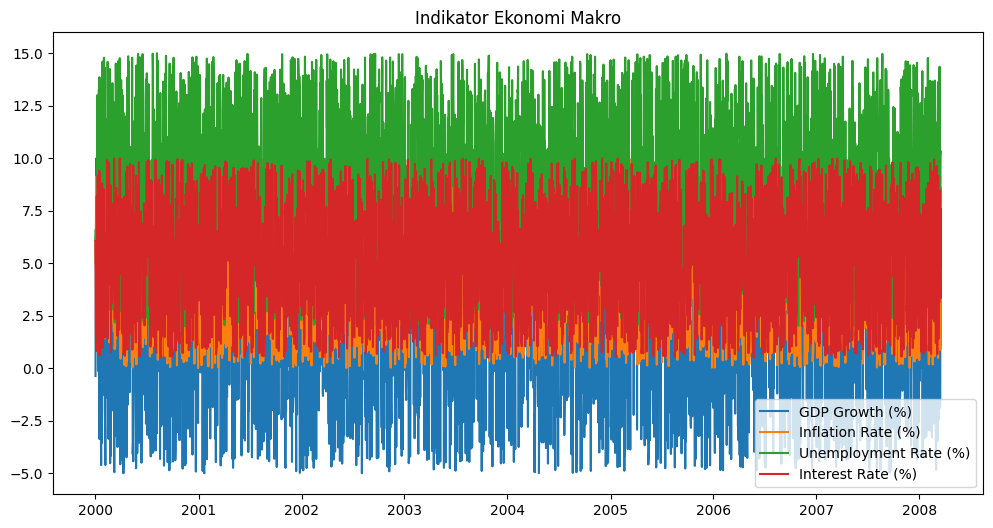

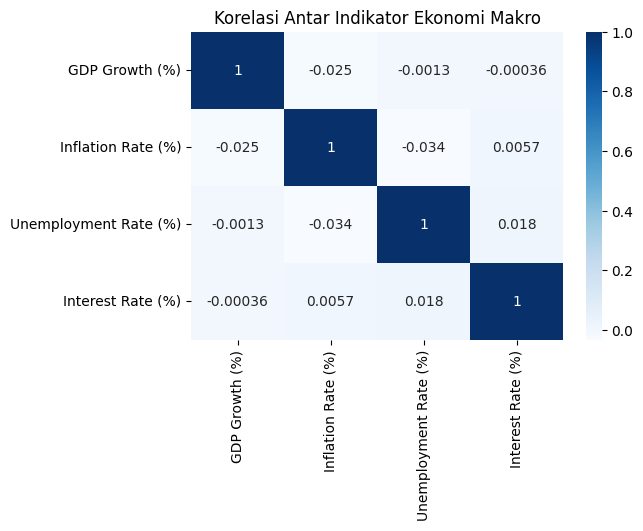

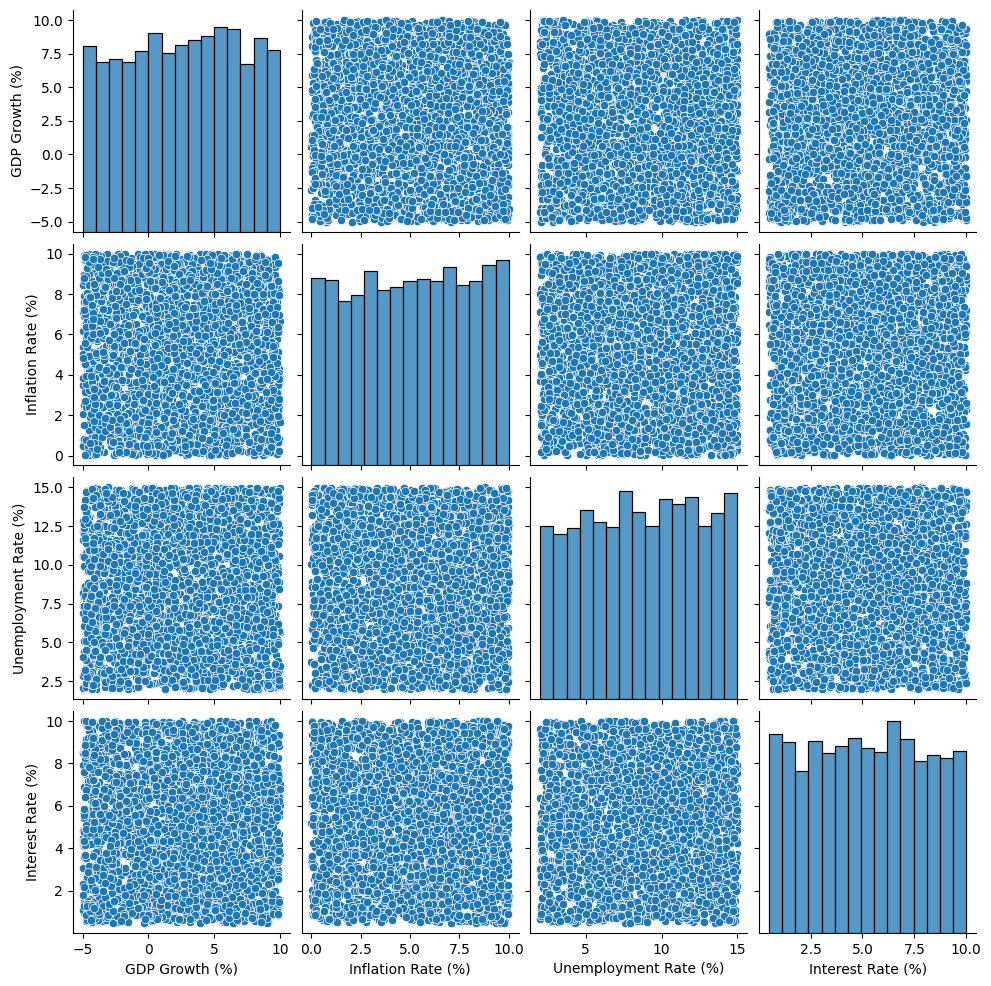

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# DAY 5–6 – EDA
# ============================================================

# Plot masing-masing indikator
plt.figure(figsize=(12, 6))
for c in macro_cols:
    plt.plot(df_macro.index, df_macro[c], label=c)
plt.title("Indikator Ekonomi Makro")
plt.legend()
plt.show()

# Korelasi antar variabel
plt.figure(figsize=(6, 4))
sns.heatmap(df_macro.corr(), annot=True, cmap="Blues")
plt.title("Korelasi Antar Indikator Ekonomi Makro")
plt.show()

# Pairplot sederhana (kalau data tidak terlalu besar)
sns.pairplot(df_macro)
plt.show()

#DAY 8–9 – Feature Engineering

In [ ]:
# ============================================================
# DAY 8–9 – Feature Engineering
#  - Lag features (GDP Growth t-1, Inflasi t-1, dll)
#  - Rolling mean (rata-rata beberapa periode ke belakang)
# ============================================================

fe_df = df_macro.copy()

# Buat lag 1 & lag 2 untuk setiap variabel
for col in macro_cols:
    fe_df[f"{col}_lag1"] = fe_df[col].shift(1)
    fe_df[f"{col}_lag2"] = fe_df[col].shift(2)

# Rolling mean 3 periode untuk GDP Growth
fe_df["GDP_Growth_rolling3"] = fe_df["GDP Growth (%)"].rolling(window=3).mean()

# Drop baris awal yang jadi NaN karena lag/rolling
fe_df = fe_df.dropna()
print("Shape setelah feature engineering:", fe_df.shape)
fe_df.head()


Shape setelah feature engineering: (2998, 13)


,GDP Growth (%),Inflation Rate (%),Unemployment Rate (%),Interest Rate (%),GDP Growth (%)_lag1,GDP Growth (%)_lag2,Inflation Rate (%)_lag1,Inflation Rate (%)_lag2,Unemployment Rate (%)_lag1,Unemployment Rate (%)_lag2,Interest Rate (%)_lag1,Interest Rate (%)_lag2,GDP_Growth_rolling3
Date,,,,,,,,,,,,,
2000-01-03,5.54,9.13,2.60,0.82,3.19,-0.37,4.95,6.06,6.62,6.10,2.19,6.06,2.786667
2000-01-04,10.00,3.77,2.20,3.71,5.54,3.19,9.13,4.95,2.60,6.62,0.82,2.19,6.243333
2000-01-05,1.53,2.20,8.20,4.56,10.00,5.54,3.77,9.13,2.20,2.60,3.71,0.82,5.690000
2000-01-06,1.42,6.08,3.24,1.09,1.53,10.00,2.20,3.77,8.20,2.20,4.56,3.71,4.316667
2000-01-07,7.64,6.24,4.52,8.24,1.42,1.53,6.08,2.20,3.24,8.20,1.09,4.56,3.530000


#DAY 8–9 – Feature Engineering

In [ ]:
# ============================================================
# DAY 8–9 – Feature Engineering
#  - Lag features (GDP Growth t-1, Inflasi t-1, dll)
#  - Rolling mean (rata-rata beberapa periode ke belakang)
# ============================================================

fe_df = df_macro.copy()

# Buat lag 1 & lag 2 untuk setiap variabel
for col in macro_cols:
    fe_df[f"{col}_lag1"] = fe_df[col].shift(1)
    fe_df[f"{col}_lag2"] = fe_df[col].shift(2)

# Rolling mean 3 periode untuk GDP Growth
fe_df["GDP_Growth_rolling3"] = fe_df["GDP Growth (%)"].rolling(window=3).mean()

# Drop baris awal yang jadi NaN karena lag/rolling
fe_df = fe_df.dropna()
print("Shape setelah feature engineering:", fe_df.shape)
fe_df.head()


Shape setelah feature engineering: (2998, 13)


,GDP Growth (%),Inflation Rate (%),Unemployment Rate (%),Interest Rate (%),GDP Growth (%)_lag1,GDP Growth (%)_lag2,Inflation Rate (%)_lag1,Inflation Rate (%)_lag2,Unemployment Rate (%)_lag1,Unemployment Rate (%)_lag2,Interest Rate (%)_lag1,Interest Rate (%)_lag2,GDP_Growth_rolling3
Date,,,,,,,,,,,,,
2000-01-03,5.54,9.13,2.60,0.82,3.19,-0.37,4.95,6.06,6.62,6.10,2.19,6.06,2.786667
2000-01-04,10.00,3.77,2.20,3.71,5.54,3.19,9.13,4.95,2.60,6.62,0.82,2.19,6.243333
2000-01-05,1.53,2.20,8.20,4.56,10.00,5.54,3.77,9.13,2.20,2.60,3.71,0.82,5.690000
2000-01-06,1.42,6.08,3.24,1.09,1.53,10.00,2.20,3.77,8.20,2.20,4.56,3.71,4.316667
2000-01-07,7.64,6.24,4.52,8.24,1.42,1.53,6.08,2.20,3.24,8.20,1.09,4.56,3.530000


In [ ]:
# ============================================================
# DAY 8–9 (Tambahan) – Feature Engineering khusus untuk LSTM
#   → fe_lstm_df : versi lebih kaya lag
#   → baseline RF tetap pakai fe_df lama (supaya angkanya tidak berubah)
# ============================================================

fe_lstm_df = df_macro.copy()

# Lag untuk semua indikator: 1, 2, 3
for col in macro_cols:
    fe_lstm_df[f"{col}_lag1"] = fe_lstm_df[col].shift(1)
    fe_lstm_df[f"{col}_lag2"] = fe_lstm_df[col].shift(2)
    fe_lstm_df[f"{col}_lag3"] = fe_lstm_df[col].shift(3)

# Tambah lag lebih panjang khusus untuk GDP Growth
for lag in [6, 12]:
    fe_lstm_df[f"GDP_Growth_lag{lag}"] = fe_lstm_df["GDP Growth (%)"].shift(lag)

# Rolling mean GDP Growth (3 dan 6 periode)
fe_lstm_df["GDP_Growth_rolling3"] = fe_lstm_df["GDP Growth (%)"].rolling(window=3).mean()
fe_lstm_df["GDP_Growth_rolling6"] = fe_lstm_df["GDP Growth (%)"].rolling(window=6).mean()

# Drop baris awal yang jadi NaN karena lag/rolling
fe_lstm_df = fe_lstm_df.dropna()
print("Shape fe_lstm_df:", fe_lstm_df.shape)
fe_lstm_df.head()


Shape fe_lstm_df: (2988, 20)


,GDP Growth (%),Inflation Rate (%),Unemployment Rate (%),Interest Rate (%),GDP Growth (%)_lag1,GDP Growth (%)_lag2,GDP Growth (%)_lag3,Inflation Rate (%)_lag1,Inflation Rate (%)_lag2,Inflation Rate (%)_lag3,Unemployment Rate (%)_lag1,Unemployment Rate (%)_lag2,Unemployment Rate (%)_lag3,Interest Rate (%)_lag1,Interest Rate (%)_lag2,Interest Rate (%)_lag3,GDP_Growth_lag6,GDP_Growth_lag12,GDP_Growth_rolling3,GDP_Growth_rolling6
Date,,,,,,,,,,,,,,,,,,,,
2000-01-13,8.14,2.12,13.28,2.30,4.13,-0.14,1.95,1.11,7.33,9.60,12.77,4.44,10.24,5.08,1.04,1.97,7.64,-0.37,4.043333,4.521667
2000-01-14,8.26,9.76,8.80,9.41,8.14,4.13,-0.14,2.12,1.11,7.33,13.28,12.77,4.44,2.30,5.08,1.04,7.08,3.19,6.843333,4.718333
2000-01-15,-3.37,7.26,13.86,0.60,8.26,8.14,4.13,9.76,2.12,1.11,8.80,13.28,12.77,9.41,2.30,5.08,5.97,5.54,4.343333,3.161667
2000-01-16,1.43,9.15,12.98,4.42,-3.37,8.26,8.14,7.26,9.76,2.12,13.86,8.80,13.28,0.60,9.41,2.30,1.95,10.00,2.106667,3.075000
2000-01-17,1.97,3.04,11.51,9.30,1.43,-3.37,8.26,9.15,7.26,9.76,12.98,13.86,8.80,4.42,0.60,9.41,-0.14,1.53,0.010000,3.426667


#DAY 10 – Baseline Modeling (Classical ML)

RandomForest (Baseline) → MAE: 1.1216, RMSE: 1.3790, R²: 0.8951


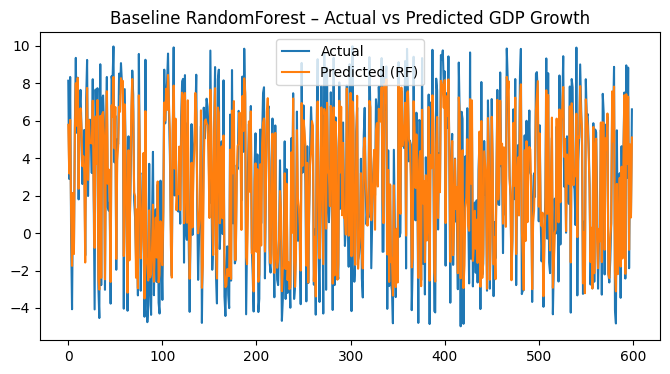

In [ ]:
# ============================================================
# DAY 10 – Baseline Modeling (Machine Learning klasik)
# Target: GDP Growth (%)
# ============================================================

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import math
import matplotlib.pyplot as plt

target_col = "GDP Growth (%)"
feature_cols = [c for c in fe_df.columns if c != target_col]

X = fe_df[feature_cols].values
y = fe_df[target_col].values

# Split time-series: 80% train, 20% test (tanpa shuffle)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=6,
    random_state=42
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

def eval_regression(y_true, y_pred, name="Model"):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    print(f"{name} → MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")
    return mae, rmse, r2

baseline_mae, baseline_rmse, baseline_r2 = eval_regression(y_test, y_pred_rf, "RandomForest (Baseline)")

plt.figure(figsize=(8,4))
plt.plot(y_test, label="Actual")
plt.plot(y_pred_rf, label="Predicted (RF)")
plt.legend()
plt.title("Baseline RandomForest – Actual vs Predicted GDP Growth")
plt.show()

#DAY 11 – Persiapan Data LSTM Multivariate

Siapkan data untuk LSTM (multivariate, dengan split train/val/test)

In [ ]:
# ============================================================
# DAY 11 – Persiapan Data untuk Bidirectional LSTM (pakai fe_lstm_df)
# ============================================================

target_col = "GDP Growth (%)"
feature_cols_lstm = [c for c in fe_lstm_df.columns if c != target_col]

# Pastikan urutan waktu
fe_lstm_df = fe_lstm_df.sort_index()

X_raw = fe_lstm_df[feature_cols_lstm].values
y_raw = fe_lstm_df[[target_col]].values

n_samples = len(fe_lstm_df)
print("Total sampel (fe_lstm_df):", n_samples)

# Split 60% train, 20% val, 20% test (time-based)
test_size = int(0.2 * n_samples)
val_size  = int(0.2 * n_samples)
train_end = n_samples - test_size - val_size
val_end   = n_samples - test_size

print("Train index  : 0  s/d", train_end-1)
print("Val index    :", train_end, "s/d", val_end-1)
print("Test index   :", val_end, "s/d", n_samples-1)

# Scaling (fit hanya di TRAIN)
scaler_X = MinMaxScaler(feature_range=(0,1))
scaler_y = MinMaxScaler(feature_range=(0,1))

X_train_raw = X_raw[:train_end]
y_train_raw = y_raw[:train_end]

scaler_X.fit(X_train_raw)
scaler_y.fit(y_train_raw)

X_scaled = scaler_X.transform(X_raw)
y_scaled = scaler_y.transform(y_raw)

def create_windows(X, y, time_step=4):
    """
    Kita pakai time_step kecil (4) karena history jangka panjang
    sudah diwakili oleh fitur lag (1,2,3,6,12).
    """
    Xs, ys, idx = [], [], []
    for i in range(len(X) - time_step):
        Xs.append(X[i:i+time_step, :])
        ys.append(y[i+time_step, 0])
        idx.append(i+time_step)
    return np.array(Xs), np.array(ys), np.array(idx)

time_step = 4  # pendek, tapi vektornya kaya (banyak fitur lag)
X_all, y_all, idx_all = create_windows(X_scaled, y_scaled, time_step=time_step)

print("X_all shape:", X_all.shape)
print("y_all shape:", y_all.shape)

train_mask = idx_all < train_end
val_mask   = (idx_all >= train_end) & (idx_all < val_end)
test_mask  = idx_all >= val_end

X_train_lstm, y_train_lstm = X_all[train_mask], y_all[train_mask]
X_val_lstm,   y_val_lstm   = X_all[val_mask],   y_all[val_mask]
X_test_lstm,  y_test_lstm  = X_all[test_mask],  y_all[test_mask]

print("Train windows:", X_train_lstm.shape, y_train_lstm.shape)
print("Val   windows:", X_val_lstm.shape,   y_val_lstm.shape)
print("Test  windows:", X_test_lstm.shape,  y_test_lstm.shape)


Total sampel (fe_lstm_df): 2988
Train index  : 0  s/d 1793
Val index    : 1794 s/d 2390
Test index   : 2391 s/d 2987
X_all shape: (2984, 4, 19)
y_all shape: (2984,)
Train windows: (1790, 4, 19) (1790,)
Val   windows: (597, 4, 19) (597,)
Test  windows: (597, 4, 19) (597,)


#DAY 12 – Arsitektur LSTM + Hyperparameter Tuning

In [ ]:
# ============================================================
# DAY 12 – Bidirectional LSTM + Hyperparameter Tuning
# ============================================================
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau

def build_bilstm_model(
    time_steps,
    n_features,
    units=64,
    dropout_rate=0.2,
    learning_rate=0.001
):
    model = Sequential()
    # BiLSTM pertama
    model.add(
        Bidirectional(
            LSTM(units=units, return_sequences=True),
            input_shape=(time_steps, n_features)
        )
    )
    model.add(Dropout(dropout_rate))
    # BiLSTM kedua
    model.add(Bidirectional(LSTM(units=units)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(1))
    model.compile(
        loss="mean_squared_error",
        optimizer=Adam(learning_rate=learning_rate)
    )
    return model

param_grid = {
    "units": [64, 128],
    "dropout_rate": [0.2, 0.3],
    "learning_rate": [0.001, 0.0005],
    "batch_size": [16, 32],
    "epochs": [60]   # nanti dipotong EarlyStopping
}

best_config = None
best_val_rmse = float("inf")
run_id = 0

for units in param_grid["units"]:
    for dr in param_grid["dropout_rate"]:
        for lr in param_grid["learning_rate"]:
            for bs in param_grid["batch_size"]:
                run_id += 1
                print(f"\n=== RUN {run_id}: units={units}, dropout={dr}, lr={lr}, batch_size={bs} ===")

                model = build_bilstm_model(
                    time_steps=time_step,
                    n_features=X_train_lstm.shape[2],
                    units=units,
                    dropout_rate=dr,
                    learning_rate=lr
                )

                early_stop = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
                reduce_lr  = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5, verbose=0)

                history = model.fit(
                    X_train_lstm, y_train_lstm,
                    validation_data=(X_val_lstm, y_val_lstm),
                    epochs=param_grid["epochs"][0],
                    batch_size=bs,
                    verbose=0,
                    callbacks=[early_stop, reduce_lr]
                )

                y_val_pred_scaled = model.predict(X_val_lstm)
                y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
                y_val_true = scaler_y.inverse_transform(y_val_lstm.reshape(-1,1))

                val_rmse = math.sqrt(mean_squared_error(y_val_true, y_val_pred))
                print(f"Val RMSE: {val_rmse:.4f}")

                if val_rmse < best_val_rmse:
                    best_val_rmse = val_rmse
                    best_config = {
                        "units": units,
                        "dropout_rate": dr,
                        "learning_rate": lr,
                        "batch_size": bs
                    }

print("\n===== BEST CONFIG BiLSTM =====")
print(best_config)
print("Best Val RMSE:", best_val_rmse)


=== RUN 1: units=64, dropout=0.2, lr=0.001, batch_size=16 ===
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
Val RMSE: 4.3104

=== RUN 2: units=64, dropout=0.2, lr=0.001, batch_size=32 ===
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
Val RMSE: 4.3143

=== RUN 3: units=64, dropout=0.2, lr=0.0005, batch_size=16 ===
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Val RMSE: 4.3091

=== RUN 4: units=64, dropout=0.2, lr=0.0005, batch_size=32 ===
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Val RMSE: 4.3287

=== RUN 5: units=64, dropout=0.3, lr=0.001, batch_size=16 ===
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Val RMSE: 4.3028

=== RUN 6: units=64, dropout=0.3, lr=0.001, batch_size=32 ===
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
Val RMSE: 4.3215

=== RUN 7: units=64, dropout=0.3, lr=0.0005, batch_size=16 ===
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Val RMSE: 4.3252

=== RUN 8: units=64, dropout=0.3, lr=0.0005, batch_size=32 ===
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Val RMSE: 4.3188

=== RUN 9: units=128, dropout=0.2, 

#Day 15–16: Train Final BiLSTM + Evaluasi Test

Epoch 1/80
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.1104
Epoch 2/80
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0895
Epoch 3/80
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0859
Epoch 4/80
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0853
Epoch 5/80
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0851
Epoch 6/80
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0843
Epoch 7/80
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0808
Epoch 8/80
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0827
Epoch 9/80
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0823
Epoch 10/80
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0844
Epoch 11/80
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0823
Epoch 12/80
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0823
Epoch 13/80
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0847
Epoch 14/80
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0856
Epoch 15/80
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s

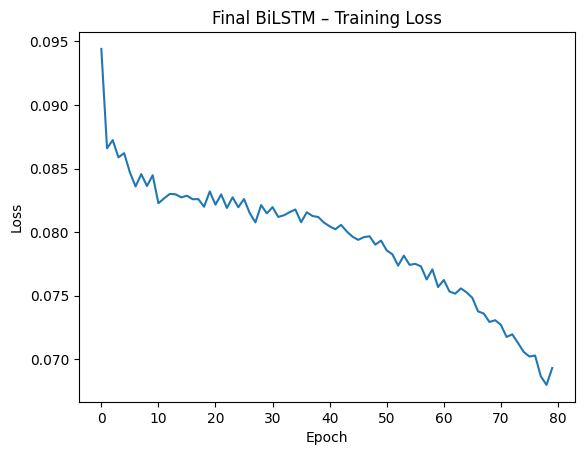

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step

===== EVALUASI BiLSTM DI TEST SET =====
MAE  BiLSTM : 3.9758
RMSE BiLSTM : 4.6936
R²   BiLSTM : -0.2156

Baseline RF → MAE: 1.1216, RMSE: 1.3790, R²: 0.8951


In [ ]:
# ============================================================
# DAY 15–16 – Train Final BiLSTM dan Evaluasi di Test Set
# ============================================================

X_trainval = np.concatenate([X_train_lstm, X_val_lstm], axis=0)
y_trainval = np.concatenate([y_train_lstm, y_val_lstm], axis=0)

best_model = build_bilstm_model(
    time_steps=time_step,
    n_features=X_trainval.shape[2],
    units=best_config["units"],
    dropout_rate=best_config["dropout_rate"],
    learning_rate=best_config["learning_rate"]
)

early_stop_final = EarlyStopping(monitor="loss", patience=12, restore_best_weights=True)

history_final = best_model.fit(
    X_trainval, y_trainval,
    epochs=80,
    batch_size=best_config["batch_size"],
    verbose=1,
    callbacks=[early_stop_final]
)

plt.plot(history_final.history["loss"])
plt.title("Final BiLSTM – Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Evaluasi di TEST
y_test_pred_scaled = best_model.predict(X_test_lstm)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
y_test_true = scaler_y.inverse_transform(y_test_lstm.reshape(-1,1))

test_mae  = mean_absolute_error(y_test_true, y_test_pred)
test_rmse = math.sqrt(mean_squared_error(y_test_true, y_test_pred))
test_r2   = r2_score(y_test_true, y_test_pred)

print("\n===== EVALUASI BiLSTM DI TEST SET =====")
print(f"MAE  BiLSTM : {test_mae:.4f}")
print(f"RMSE BiLSTM : {test_rmse:.4f}")
print(f"R²   BiLSTM : {test_r2:.4f}")
print("\nBaseline RF → MAE: %.4f, RMSE: %.4f, R²: %.4f" % (baseline_mae, baseline_rmse, baseline_r2))
